**SECTION 0: Mounting the drive**

In [ ]:
# Mounting the drive 

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


**SECTION 1: Importing necessary Library**

In [ ]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
import pickle

In [ ]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 

from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.layers import Input

**SECTION 2: Importing csv file**

In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/Research/DainikBhasker_Cleaned.csv"
df = pd.read_csv(path)
df.head()

Datetime  ...                                          Image Url
0  2020-08-31 17:14:38+00:00  ...     http://pbs.twimg.com/media/Egw9miWXkAM1BiB.jpg
1  2020-08-31 15:00:00+00:00  ...     http://pbs.twimg.com/media/EgwZyyNU4AA9nFA.jpg
2  2020-08-31 14:45:00+00:00  ...     http://pbs.twimg.com/media/EgwXkeeUwAANkUZ.jpg
3  2020-08-31 13:44:06+00:00  ...  http://pbs.twimg.com/ext_tw_video_thumb/130042...
4  2020-08-31 12:46:41+00:00  ...     http://pbs.twimg.com/media/EgwARjgXsAY9r3b.jpg

[5 rows x 6 columns]

**SECTION3 : Downloading the Image**

In [ ]:
# !pip install wget

In [ ]:
# #this cell is for downloading the photos so run it only a single time ... plus downloading will take some time 
# import wget 

# for i in range(0,len(df)):

#     try:
#       wget.download(df['Image Url'][i],"/content/drive/MyDrive/Tweet Image DB/"+str(df_dj['Tweet Id'][i])+".jpg")
#     except:
#       i+=1

**SECTION 4 : Image name storage**

In [ ]:
path = r"/content/drive/MyDrive/Research/Tweet Image DB"
os.chdir(path)

image_name =[]  # to store the names of image files (Tweet ID.jpg)
with os.scandir(path) as files:

    for file in files:
      image_name.append(file.name)

print(len(image_name))

51005


In [ ]:
image_id = [] # to store the integer value of Tweet ID so that later we can iterate over it !!
for i in image_name:
  image_id.append(int(i.split(".")[0]))

print(len(image_id))
with open('/content/image_id.pkl', 'wb') as f:
  pickle.dump(image_id, f)

51005


In [ ]:
# dictionary to convert Tweet ID into int index value ---> which stores the index at which our feat vec or cosine sim value is stored
id_to_index = {} 
index_to_id = {} 

count_k = 0
for dp in image_id:
  id_to_index[dp] = count_k
  index_to_id[count_k] = dp
  count_k +=1

**SECTION 5: To store and retreive the feature vector of Image**

In [ ]:
#Importing DenseNet model for feat extraction
model = DenseNet121(weights='imagenet', include_top=False)

In [ ]:
# This function will take the Image and convert it into the Feature vec(length = 50176 for DenseNet)

def extract_features(file,model):
    
    img = load_img(file,target_size=(224,224))
    
    img = img_to_array(img)
    reshaped_img = np.expand_dims(img,axis=0)
    
    imgx = preprocess_input(reshaped_img)
    features = model.predict(imgx)

    features = features.flatten()
    
    return features

In [ ]:
#this cell is for feat extraction (dict containing every feat vec) data[Tweet ID] = feat vec

data = {}
count = 0
for fl in image_name[10000:20000]:
    feat = extract_features(fl,model)
    data[int(fl.split('.')[0])] = feat
    count +=1 
    if count %500 == 0:
      print (count)

In [ ]:
# for storing the "data" dict containing the extracted feat into pickle file and saving it for later use

a_file = open("/content/drive/MyDrive/Extracted Features/batch7.pkl","wb")
pickle.dump(data,a_file)
a_file.close()

In [ ]:
# This is the code for importing or reloading the extracted features of image back into the dict for later use
extracted_image_feat = {}

a_file = open('/content/drive/MyDrive/Extracted Features/Hindi_batch1.pkl', "rb")
output = pickle.load(a_file)

a_file.close()
extracted_image_feat = output

a_file = open('/content/drive/MyDrive/Extracted Features/Hindi_batch2.pkl', "rb")
output = pickle.load(a_file)

a_file.close()
extracted_image_feat.update(output)

a_file = open('/content/drive/MyDrive/Extracted Features/Hindi_batch3.pkl', "rb")
output = pickle.load(a_file)

a_file.close()
extracted_image_feat.update(output)

a_file = open('/content/drive/MyDrive/Extracted Features/Hindi_batch4.pkl', "rb")
output = pickle.load(a_file)

a_file.close()
extracted_image_feat.update(output)

a_file = open('/content/drive/MyDrive/Extracted Features/Hindi_batch5.pkl', "rb")
output = pickle.load(a_file)

a_file.close()
extracted_image_feat.update(output)

print(len(extracted_image_feat))

20000


**SECTION 6: For Calculating Cosine Simialrity Matrix**


In [ ]:
# Converting the extracted_image_feat dict into an array 
def dict_to_array(arg_dict):
  image_feature_array = []    #image_to_feature_Array_1, image_to_feature_Array_2 
  for img_ft in list(arg_dict.values()):
    image_feature_array.append(img_ft.reshape(1,-1))

  image_feature_array = np.array(image_feature_array)
  return image_feature_array

In [ ]:
import h5py

def find_consine_similarity_and_save(image_feature_array1, image_feature_array2, index):
  cosine_similarity_matrix = cosine_similarity(image_feature_array1, image_feature_array2 )
  path = '/content/drive/MyDrive/Research/cosine_sim_matrix' + str(index) + '.h5'
  with h5py.File(path,'w') as hf:
    hf.create_dataset(str(index), data = cosine_similarity_matrix)

In [ ]:
for i in range(0,5):
  path = '/content/drive/MyDrive/Research/Extracted Features/Hindi_batch' + str(i+1) + '.pkl'
  a_file = open(path, "rb")
  features_vector_1 = pickle.load(a_file)
  features_vector_1 = dict_to_array(features_vector_1)
  features_vector_1 = features_vector_1.reshape(features_vector_1.shape[0],50176)
  for j in range(i,5):
    extracted_image_feat = {}
    path = '/content/drive/MyDrive/Research/Extracted Features/Hindi_batch' + str(j+1) + '.pkl'
    a_file = open(path, "rb")
    features_vector_2 = pickle.load(a_file)
    features_vector_2 = dict_to_array(features_vector_2)
    features_vector_2 = features_vector_2.reshape(features_vector_2.shape[0],50176)
    find_consine_similarity_and_save(features_vector_1, features_vector_2, 5*i + j)

**Storing the cosine similarity matrix as batches**

In [ ]:
cosine_similarity_matrix = np.zeros((len(image_id), len(image_id)), dtype = np.float32)

In [ ]:
# Calculating 51k x 51k x 2048 matrix, RAM gets full. Hence they're stored in batch and at the time of calculation they're formed in the original Form.


for i in range(5, 25):
  if (i%5) < int(i/5):
    continue
  path = '/content/drive/MyDrive/Research/cosine_sim_matrix' + str(i) + '.h5'
  # cosine_similarity_matrix[0:10000, 0:10000] = partial_matrix[]
  with h5py.File(path,'r') as hf:
    partial_matrix = hf[str(i)][:]
  first_pickle_file_start = (int(i/5))*10000
  second_pickle_file_start = (i%5)*10000
  for first_file_offset in range(0, partial_matrix.shape[0]):
    for second_file_offset in range(0, partial_matrix.shape[1]):
      index1 = first_pickle_file_start + first_file_offset
      index2 = second_pickle_file_start + second_file_offset
      cosine_similarity_matrix[index1, index2] = partial_matrix[first_file_offset, second_file_offset]

In [ ]:
# with h5py.File('/content/drive/MyDrive/Research/final_cosine_sim_matrix.h5','w') as hf:
#   hf.create_dataset("Image Similarity", data = cosine_similarity_matrix)

**Load the consine similarity matrix**

In [ ]:
import h5py
# load the cosine similarity matrix
with h5py.File('/content/drive/MyDrive/Research/final_cosine_sim_matrix.h5','r') as hf:
  cosine_similarity_matrix = hf['Image Similarity'][:]

In [ ]:
# For demo
import h5py
path = '/content/drive/MyDrive/Research/cosine_sim_matrix' + '0' + '.h5'
# cosine_similarity_matrix[0:10000, 0:10000] = partial_matrix[]
with h5py.File(path,'r') as hf:
  cosine_similarity_matrix = hf['0'][:]

**SECTION 7: Storing Tweet text**

In [ ]:
# Functions for removing the unwanted links and mentions from tweets but keeping the hashtags
import re,string

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] is not '@':
                words.append(word)
    return ' '.join(words)

In [ ]:
#For storing the tweet text into dict ---> tweet_text[Tweet ID] = tweet
tweet_text = {}
for i in range(0,len(df)):
  if df['Tweet Id'][i] in image_id:
    tweet_text[int(df['Tweet Id'][i])]= strip_all_entities(strip_links(df['Text'][i]))

**SECTION 8: Tweet(Img+Text) Similarity**

In [ ]:
# Importing all the stopwords (which do not affect clustering in any way)

listt = []
f = open("/content/drive/MyDrive/Research/final_stopwords.txt","r")

for x in f:
  listt.append(x.split('\n')[0])

stopwords = set(listt)

In [ ]:
# Removing the stopwords Because they dont contribute much in storing information about the clusters

removed_stopwords = {}
for id_ in tweet_text.keys():
    str1 = tweet_text[id_]
    words_in_str1 = []
    for i in str1.split(' '):
        if i in stopwords:
          continue
        words_in_str1.append(i)
    removed_stopwords[id_] = words_in_str1

['जिंदगी', 'सफलता', 'खुश', 'रहने', 'पढ़ें', 'खास', 'विचार', 'क्लिक']
['जिंदगी', 'सफलता', 'खुश', 'रहने', 'पढ़ें', 'खास', 'विचार', 'क्लिक']


In [ ]:
# ! pip install nltk==3.6.2
from nltk.translate.bleu_score import sentence_bleu

import warnings
warnings.filterwarnings("ignore")

tempo = 0
def text_similarity(val):
  i = int(val/25000)
  j = val%25000

  str1 = removed_stopwords[index_to_id[i]]
  str2 = removed_stopwords[index_to_id[j]]
  score_1 = sentence_bleu([str2], str1, weights=(0, 0.33, 0.33, 0.34), smoothing_function = None)
  return score_1

In [ ]:
# Function for calculating overall similarity b/w 2 tweets ---> overall sim = weighted average of image + text sim 
def similarity(i,j):

  
  # img_sim = cosine_similarity_matrix[i][j]
  tweet_sim = text_similarity(i,j)
  return tweet_sim
  w1 = 0.25
  w2 = 0.75

  resultant_sim = w1*img_sim+w2*tweet_sim

  return resultant_sim

**SECTION 9: Clustering**

In [ ]:
max_img = 5
import nltk
print('The nltk version is {}.'.format(nltk.__version__))

The nltk version is 3.2.5.


In [ ]:
# load existing distance matrix (numpy array)
import h5py
with h5py.File('/content/drive/MyDrive/Research/distance_matrix.h5','r') as hf:
  distance = hf['distance_final'][:]

In [ ]:
# initializing the distance_1 dictionary (2D) as -100 , distance_1[img1][img2] = similarity between the two tweets while img1 and img2 are Tweet ID

i = 0
for x in list(distance_first_10):
  for j in range(0, 10000):
      if (x[j] == -100):
        x[j] = text_similarity(i,j)
        distance_1[j][i] = x[j]
  i+=1

In [ ]:
distance_1 = np.zeros(shape=(51005, 51005), dtype = np.float32) # create the distance matrix
distance_1.fill(-100)

In [ ]:
#first quad
# with open('/content/drive/MyDrive/Research/first 25k/distance_first_25k.pkl', 'rb') as f:
#   first_quad = pickle.load(f)
distance_1[0:25000, 0:25000] = first_quad

In [ ]:
#third quad
third = []
for i in range(0,13):
  with open('/content/drive/MyDrive/Research/third_quad/distance_' + str(i) + '.pkl', 'rb') as f:
    third.append(pickle.load(f))
print(len(third))
for i in third:
  print(i.shape)

13
(26005, 1000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)


In [ ]:
distance_1[25000:, 0:1000] = third[0]
current = 1000
for i in range(1, 13):
  distance_1[25000:, current:current+2000] = third[i]
  current += 2000

In [ ]:
#forth_quad
forth = []
for i in range(0,13):
  with open('/content/drive/MyDrive/Research/forth_quad/distance_' + str(i) + '.pkl', 'rb') as f:
    forth.append(pickle.load(f))
print(len(forth))
for i in forth:
  print(i.shape)

13
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2000)
(26005, 2005)


In [ ]:
current = 25000
for i in range(0, 12):
  distance_1[25000:, current:current+2000] = forth[i]
  current += 2000
distance_1[25000:, current:current + 2005] = forth[12]

In [ ]:
count = 0
for i in range(15500, 25000):
  for j in range(25000, 51005):
    if distance_1[i][j] == -100:
      distance_1[i][j] = distance_1[j][i]
      count +=1
  if i%100 == 0:
    print(i)

print(count)

15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600
18700
18800
18900
19000
19100
19200
19300
19400
19500
19600
19700
19800
19900
20000
20100
20200
20300
20400
20500
20600
20700
20800
20900
21000
21100
21200
21300
21400
21500
21600
21700
21800
21900
22000
22100
22200
22300
22400
22500
22600
22700
22800
22900
23000
23100
23200
23300
23400
23500
23600
23700
23800
23900
24000
24100
24200
24300
24400
24500
24600
24700
24800
24900
246360069


In [ ]:
print(np.count_nonzero(distance_1 == -100))

0


**Storing the Distance Matrix**

In [ ]:
# del cosine_similarity_matrix
# # save the distance matrix to drive
# with h5py.File('/content/drive/MyDrive/Research/distance_matrix.h5','w') as hf:
#   hf.create_dataset("distance_final", data = distance)
import h5py
# FOR DEMO
# with h5py.File('/content/drive/MyDrive/Research/distance_matrix_final_last_2_doubt.h5','w') as hf:
#   hf.create_dataset("distance", data = distance_1)
# with h5py.File('/content/drive/MyDrive/Research/distance_matrix_final_using_parts.h5','w') as hf:
#   hf.create_dataset("distance", data = distance_1)
with h5py.File('/content/drive/MyDrive/Research/distance_matrix_final_using_parts.h5','r') as hf:
  distance_1 = hf['distance'][:]
# with h5py.File('/content/drive/MyDrive/Research/distance_matrix_final_last.h5','r') as hf:
#   distance_1 = hf['distance'][:]
# with h5py.File('/content/drive/MyDrive/Research/distance_matrix_unigram_with_cosine_final.h5','w') as hf:
#   hf.create_dataset("distance", data = distance_1)
# with h5py.File('/content/drive/MyDrive/Research/distance_matrix_DEMO4_without_smoothing_fix1.h5','r') as hf:
#   distance_1 = hf['distance_DEMO4'][:]
# with h5py.File('/content/drive/MyDrive/Research/distance_matrix_DEMO1.h5','r') as hf:
#   distance_1 = hf['distance_DEMO1'][:]

In [ ]:
# sort each dictionary

res = {}
for i in range(0, 10000):
  # path = '/content/sample_data/dicts/' + str(i) + ".pkl"
  one_row_dict = {}
  for j in range(0, 10000):
    one_row_dict[index_to_id[j]] = distance_1[i][j]
  data = {k: v for k, v in sorted(one_row_dict.items(), key=lambda item: item[1], reverse = True)}
  # a_file = open(path,"wb")
  # pickle.dump(data,a_file)
  res[index_to_id[i]] = data

In [ ]:
# sorting the dictionary in descending order
# res = {key : dict(sorted(val.items(), key = lambda ele: ele[1],reverse=True)) for key, val in distance.items()}

In [ ]:
# Calculating the max sim of every tweet


# dict to store the maximum simialrity -----> max_sim[Tweet ID] = value
max_sim ={}

# dict to store the maximum of tweet is found with which tweet ----> max_of[Tweet ID1] = Tweet ID2 ---> max sim of tweet ID1 is with tweet ID2
max_of = {} 

count = 0

for dp1 in id_to_index.keys():
  if count%1000 == 0:
    print('Done with ', count)
  dp1_index = id_to_index[dp1]
  for dp2 in id_to_index.keys():
    dp2_index = id_to_index[dp2]
    if dp1 == dp2:
      continue

    if dp2 in max_sim.keys():
      if (max_sim[dp2] < distance_1[dp1_index, dp2_index]):
        max_sim[dp2] = distance_1[dp1_index, dp2_index]
        max_of[dp2] = dp1
    else:
      max_sim[dp2] = distance_1[dp1_index, dp2_index]
      max_of[dp2] = dp1
  count += 1


Done with  0
Done with  1000
Done with  2000
Done with  3000
Done with  4000
Done with  5000
Done with  6000
Done with  7000
Done with  8000
Done with  9000
Done with  10000
Done with  11000
Done with  12000
Done with  13000
Done with  14000
Done with  15000
Done with  16000
Done with  17000
Done with  18000
Done with  19000
Done with  20000
Done with  21000
Done with  22000
Done with  23000
Done with  24000
Done with  25000
Done with  26000
Done with  27000
Done with  28000
Done with  29000
Done with  30000
Done with  31000
Done with  32000
Done with  33000
Done with  34000
Done with  35000
Done with  36000
Done with  37000
Done with  38000
Done with  39000
Done with  40000
Done with  41000
Done with  42000
Done with  43000
Done with  44000
Done with  45000
Done with  46000
Done with  47000
Done with  48000
Done with  49000
Done with  50000
Done with  51000


In [ ]:
import pickle

# read max_of and max_sim
a_file = open('/content/drive/MyDrive/Research/max_sim.pkl', 'rb')
max_sim = pickle.load(a_file)
a_file.close()
a_file = open('/content/drive/MyDrive/Research/max_of.pkl', 'rb')
max_of = pickle.load(a_file)
a_file.close()

In [ ]:
with open('/content/drive/MyDrive/Research/id_to_index.pkl', 'rb') as f:
  id_to_index = pickle.load(f)
with open('/content/drive/MyDrive/Research/index_to_id.pkl', 'rb') as f:
  index_to_id = pickle.load(f)

In [ ]:
# For deleting the non-max duplicates present over the dictionary


count = 0
res = {}
for dp1 in max_sim.keys():
  if count%3000 == 0:
    with open('/content/drive/MyDrive/Research/res/' + str(count), 'wb') as f:
      pickle.dump(res, f)
      del res
      res = {}
    print(count)
  dp1_index = id_to_index[dp1]
  one_row_dict = dict(enumerate(distance_1[dp1_index], 0))
  for dp2 in max_of.keys():
    if dp2 == dp1:
      continue
    dp2_index = id_to_index[dp2]
    if max_of[dp2] == dp1:
      continue
    else:
      one_row_dict.pop(dp2_index)
  res[dp1_index] = one_row_dict
  count += 1


0
3000
6000
9000
12000
15000
18000
21000
24000
27000
30000
33000
36000
39000
42000
45000
48000
51000


In [ ]:
with open('/content/drive/MyDrive/Research/res/' + str(51005), 'wb') as f:
  pickle.dump(res, f)

In [ ]:
count = 0
res = {}
while(1):
  with open('/content/drive/MyDrive/Research/res/' + str(count*3000), 'rb') as f:
      temp = pickle.load(f)
      res.update(temp)
  if count*3000 == 51000:
    break
  count += 1
with open('/content/drive/MyDrive/Research/res/' + str(51005), 'rb') as f:
    temp = pickle.load(f)
    res.update(temp)


In [ ]:
# with open('/content/drive/MyDrive/Research/final_dict.pkl', 'rb') as f:
#   res = pickle.load(f)

In [ ]:
 # Code for checking the condition where we'll have tweets in two rows .... that is its own row and other row which have max sim of this tweet 
 # we'll count average similarity of the target tweet in its own row and other row whoever has more we'll be assigning the tweet to that row / cluster
 
 for dp1 in max_sim.keys():
  dp1_in = id_to_index[dp1]
  avg_own = 0
  avg_other = 0
  k=0

  if dp1_in in res.keys(): # check if dp1 is deleted or not
    for dp2_in in res[dp1_in].keys(): # res[dp1]
      dp2 = index_to_id[dp2_in]
      if k>=5:
        break
      elif k<5 and dp1!=dp2:
        avg_own += res[dp1_in][dp2_in]
        k+=1
   
    if k > 0:
      avg_own=avg_own/k
    k=0
    
    if id_to_index[max_of[dp1]] in res.keys() and dp1_in in res[id_to_index[max_of[dp1]]]: # res[max_of[dp1]] and delete checking
      for dp3_in in res[id_to_index[max_of[dp1]]].keys():
        dp3 = index_to_id[dp3_in]
        if k>=5:
          break
        elif k<5 and dp3!=dp1:
          avg_other += distance_1[id_to_index[dp1]][id_to_index[dp3]]
          k+=1
     
      if k > 0:
        avg_other = avg_other/k
      
      if avg_own >= avg_other:
        res[id_to_index[max_of[dp1]]].pop(dp1_in)
      
      else:
        res.pop(dp1_in)

In [ ]:
# num of clusters 
len(res)
temp = {}
for i in res.keys():
  size = len(res[i])
  if size in temp.keys():
    temp[size] = temp[size] + 1
  else:
    temp[size] = 1
print(temp)

with open('/content/res.pkl', 'wb') as f:
  pickle.dump(res, f)

{1: 20870, 2: 1626, 3: 172, 12: 12, 9: 11, 18: 7, 5: 63, 7: 25, 16: 7, 4: 81, 6: 62, 4844: 1, 803: 1, 903: 1, 622: 1, 370: 2, 534: 1, 882: 1, 347: 1, 302: 1, 1043: 1, 124: 1, 1018: 1, 595: 1, 229: 1, 290: 2, 440: 2, 766: 1, 426: 1, 138: 1, 540: 1, 228: 1, 226: 1, 108: 1, 280: 1, 80: 1, 104: 1, 232: 1, 151: 1, 50: 2, 112: 1, 239: 1, 168: 1, 30: 4, 65: 1, 342: 1, 70: 1, 78: 1, 208: 1, 31: 1, 134: 1, 111: 1, 42: 2, 131: 1, 478: 1, 53: 1, 19: 7, 76: 1, 120: 1, 119: 1, 25: 3, 15: 12, 113: 1, 98: 1, 60: 1, 182: 1, 79: 1, 17: 11, 57: 1, 38: 2, 77: 1, 11: 6, 37: 1, 51: 1, 45: 1, 36: 3, 149: 1, 71: 1, 72: 2, 8: 22, 20: 1, 23: 3, 22: 6, 10: 9, 33: 1, 56: 1, 14: 7, 27: 1, 34: 1, 24: 1, 21: 5, 35: 1, 41: 1, 62: 1, 105: 1, 29: 4, 90: 1, 61: 1, 43: 1, 52: 1, 13: 4, 28: 1, 66: 1, 46: 1, 32: 2}


**SECTION 10: Results**

In [ ]:
# adding single clusters
for dp1_in in range(0, 51005):
  if dp1_in not in res.keys():
    res[dp1_in] = {}


groups = {}
cluster = 1
k=0
path = '/content/drive/MyDrive/Research/Tweet Image DB/'
for dp1_in in res.keys():
  dp1 = index_to_id[dp1_in]
  groups[cluster] = []
  groups[cluster].append(path + str(dp1)+'.jpg')
  for dp2_in in res[dp1_in].keys():
    dp2 = index_to_id[dp2_in]
    if k>=6:
      break
    else:
      k+=1
      groups[cluster].append(path + str(dp2)+'.jpg')

  cluster+=1
  k=0

In [ ]:
import matplotlib.pyplot as plt

def view_cluster(cluster):
    #plt.figure(figsize = (30,30));
    files = groups[cluster]
    count_img=0
    
    for index, file in enumerate(files):
        tweet_id_from_file = int(file.split('/')[-1].split('.')[0])
        if index == 0:
          dp1_id = id_to_index[tweet_id_from_file]
        dp2_id = id_to_index[tweet_id_from_file]
        if count_img > 25:
          break
        #plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off') #Nothing to see for now 
        count_img+=1
        print(dp2_id)
        print(distance_1[dp1_id][dp2_id], "\n",tweet_text[tweet_id_from_file])
        plt.show()

2
1.0 
 12 साल से पिता ही कर रहा था 15 साल की बेटी का यौन शोषण


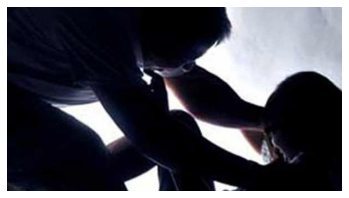

In [ ]:
view_cluster(3)

In [ ]:
def neighbourhood(count1,count2,tweet_cap1,tweet_cap2,threshold):

    sim_calc = similarity(count1,count2,tweet_cap1,tweet_cap2) 
    if sim_calc < threshold:
      return 0
    
    return sim_calc >= threshold

In [ ]:
sizes = {}
for i in groups.keys():
  if len(groups[i]) in sizes.keys():
    sizes[len(groups[i])] += 1
  else:
    sizes[len(groups[i])] = 1

In [ ]:
print(sizes)

temp = set()
for i in groups.keys():
  for j in groups[i]:
    temp.add(j)

print("\nTotal Image in the all the Clusters: ",len(temp))
# cluster_wise_images = np.zeros(6,dtype=int)

with open('/content/drive/MyDrive/Research/final_clusters.pkl', 'wb') as f:
  pickle.dump(groups, f)

{2: 20870, 3: 1626, 4: 172, 7: 317, 6: 63, 5: 81, 1: 27876}

Total Image in the all the Clusters:  51005


**Printing the Clusters**

18092
1.0 
 31 नामों के चलते अखिलेश ने की मुलायम से बगावत अपनी अलग लिस्ट में अपर्णा का नाम काटा माफियाओं को टिकट दिया


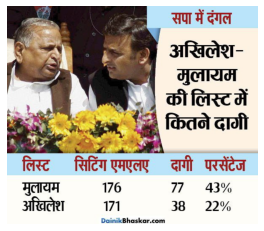

18094
0.6189318 
 31 नामों के चलते #अखिलेश ने की #मुलायम से बगावत अपनी अलग लिस्ट में अपर्णा का नाम काटा माफियाओं को टिकट दिया


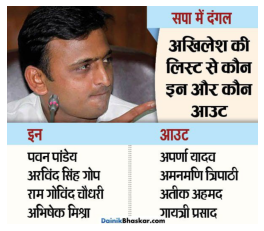

25771
1.0 
 स्मार्ट सिटी की अाखिरी लिस्ट जारी सतना सागर पटना समेत 30 शहरों के नाम #SmartCities


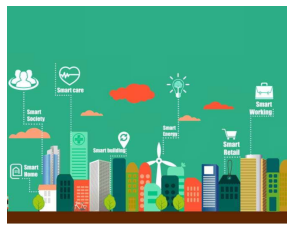

Next set coming




17481
1.0 
 IG ने DGP को भेजा सुसाइड मैसेज लिखा परेशान करते हो जान दे दूंगा #Maharashtra


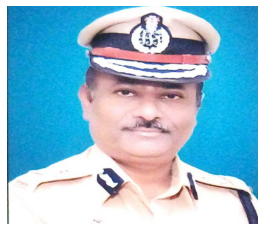

39973
1.0 
 #छत्तीसगढ़ आरोपियों ने दुष्कर्म के बाद लड़की को पेड़ से लटकाया दुपट्‌टे का फंदा खुलने से जान बची #ChhattisgarhNews


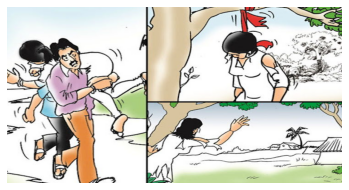

50020
0.4345982 
 रैना के लिए वॉटसन का मैसेज #SureshRaina #ShaneWatson #IPL


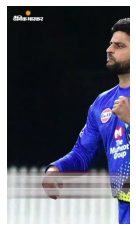

Next set coming




17405
1.0 
 नोटबंदीः सुबह से ही ATMs के बाहर फिर लोगों की भीड़ रविवार होने पर भी बैंक खुलेंगे #noteban


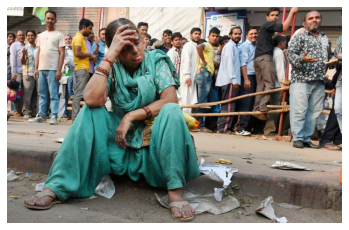

27398
1.0 
 पिंकसिटी में सुबह से हो रही झमाझम बारिश किसी के लिए राहत तो कहीं आफत #jaipur #Monsoon2017


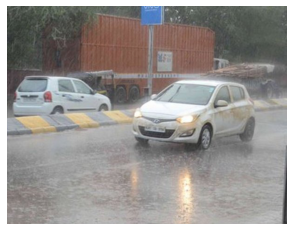

41971
1.0 
 उन्नाव रेप पीड़िता का रविवार को कड़ी सुरक्षा के बीच अंतिम संस्कार कर दिया गया #UnnaoCase #UttarPradesh


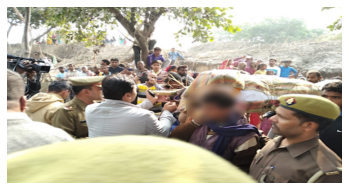

Next set coming




17431
1.0 
 जापान की बुलेट ट्रेन में बैठे मोदी हाईस्पीड टेक्नोलॉजी देखने फैक्ट्री भी जाएंगे


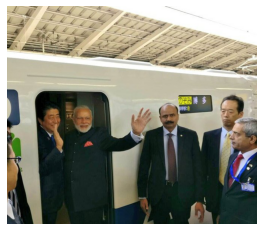

40579
1.0 
 विश्व टेलीविजन दिवस पानीपत का एक गांव ऐसा भी जहां टीवी देखने की मनाही #WorldTelevisionDay2019


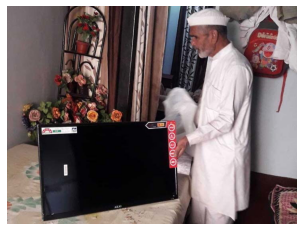

41985
1.0 
 दिल्ली के रिहाइशी इलाके की फैक्ट्री में आग हादसे की भयावह फोटोज #DelhiFire #delhifireaccident


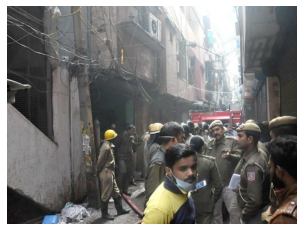

Next set coming




17464
1.0 
 सिंधु समझौते पर पाक की शिकायत पर वर्ल्ड बैंक ने बनाई कोर्ट भारत ने जताया एतराज


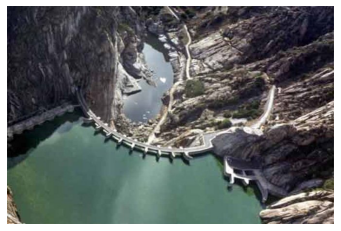

27273
1.0 
 वर्ल्ड बैडमिंटन चैम्पियनशिप में गोल्ड से चूकीं सिंधु जापानी शटलर ने हराया #WBC2017 #worldbadmintonchampionship


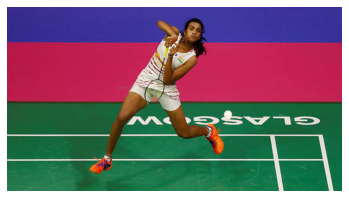

38289
1.0 
 वर्ल्ड एथलेटिक्स अविनाश टोक्यो ओलिंपिक के लिए क्वालिफाई 3000 मीटर स्टीपलचेज में 13वें स्थान पर रहे #Tokyo2020


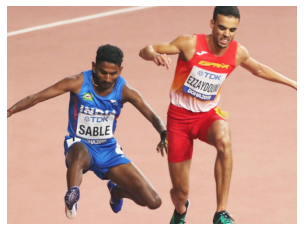

Next set coming






In [ ]:
count = 0
import random
temp = list(groups.keys())
random.shuffle(temp)
for i in temp:
  if count == 5:
    break
  if len(groups[i]) == 3:
    view_cluster(i)
    count += 1

    print('Next set coming\n\n\n\n')

18026
1.0 
 आस्ट्रेलिया के सिडनी में हुई नए साल के जश्न में अतिशबाजी नए साल का हुआ आगाज


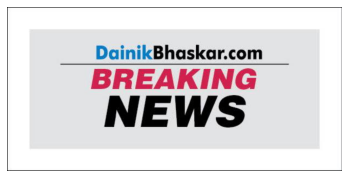

18026
1.0 
 आस्ट्रेलिया के सिडनी में हुई नए साल के जश्न में अतिशबाजी नए साल का हुआ आगाज


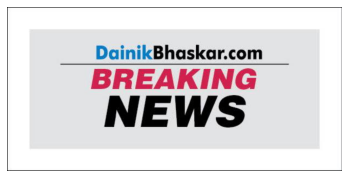

28067
0.7514773 
 किसी DSLR कैमरा की तरह हैं Google के नए स्मार्टफोन ये है कीमत #Pixel


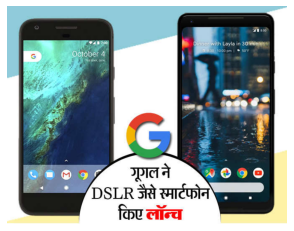

28601
0.8824969 
 एंड्रॉइड स्मार्टफोन से लिए गए नए iPhone के फीचर्स यहां से हुए कॉपी #AppleEvent #Note8


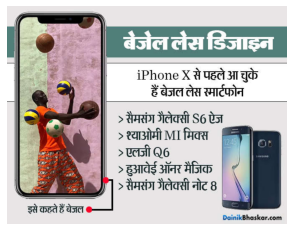

39720
1.0 
 पुष्य नक्षत्र है अवसर नए शुभारम्भों का। तो आईये करें शुभ शुरुआत।


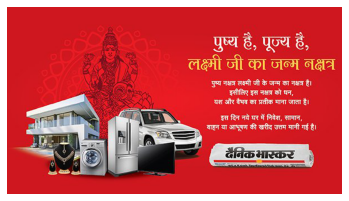

Next set coming




26698
1.0 
 LIVE 5 जजों की बेंच में जस्टिस आसिफ सईद खोसा एजाज अफजल खान गुलजार अहमद शेख अजमद सईद और इजाजुल अहसान शामिल हैं।


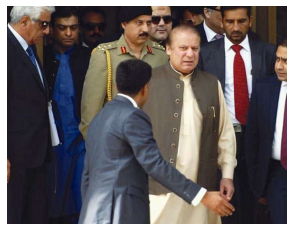

17803
1.0 
 #JammuKashmir में 23 घंटे से क्राॅस बॉर्डर फायरिंग जारीः 11 लोग जख्मी पाकिस्तान के 3 सैनिक मारे गए 5 चौकियां तबाह


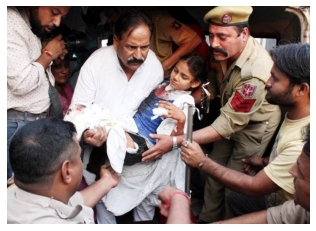

18196
1.0 
 #NoteBandi के 48 दिन 5 इकोनॉमिस्ट्स की राय जड़ें जमा चुका करप्शन इससे खत्म नहीं होगा इससे पूरी इकोनॉमी हिल जाएगी


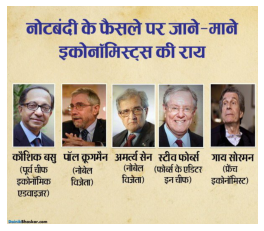

18974
1.0 
 सरकारी अफसरों के ठिकानों पर छापे 152 करोड़ की बेहिसाबी संपत्ति मिली नई करंसी में 5 7 करोड़ रु की सबसे बड़ी जब्ती


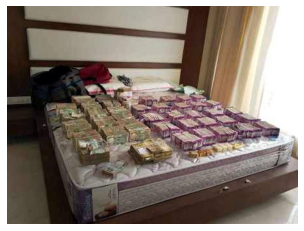

26698
1.0 
 LIVE 5 जजों की बेंच में जस्टिस आसिफ सईद खोसा एजाज अफजल खान गुलजार अहमद शेख अजमद सईद और इजाजुल अहसान शामिल हैं।


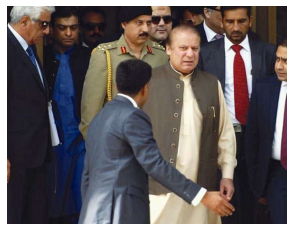

Next set coming




25164
1.0 
 कोविंद का सहायक बनना सौभाग्य होगा मोदी BJP का दावा 40 पार्टियों का सपोर्ट #PresidentialElection


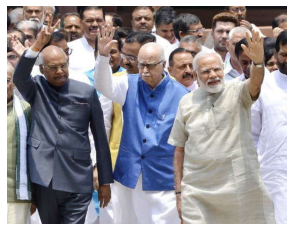

17447
1.0 
 मोदी ने की जापान के पीएम शिंजो आबे से मुलाकात न्यूक्लियर डील पर बन सकती है बात


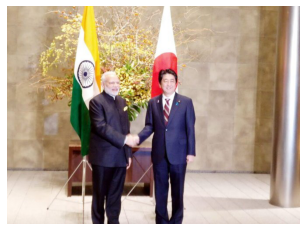

17554
1.0 
 सांप सीढ़ी के अंकों का गणित स्वर्ग नर्क से जुड़ा है इस खेल का रिश्ता रिसर्च में दावा


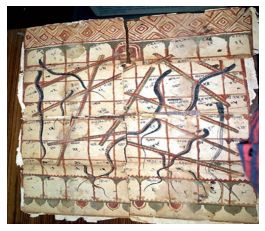

18646
1.0 
 #BhaskarUtsavRajasthan रामदेव बोले रणवीर चुलबुला मोदी को बताया फेवरेट एक्टर पर डिनर की चाहत वसुंधरा के साथ


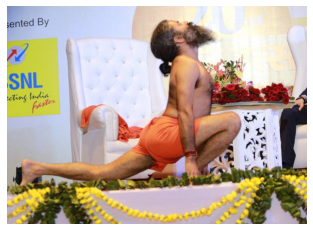

25164
1.0 
 कोविंद का सहायक बनना सौभाग्य होगा मोदी BJP का दावा 40 पार्टियों का सपोर्ट #PresidentialElection


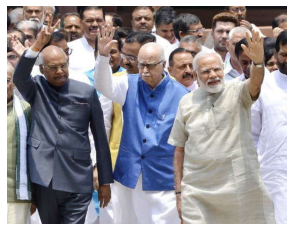

Next set coming




17224
1.0 
 1 11 करोड़ की ब्लैकमनी के साथ बिजनेसमैन अरेस्ट पुराने 1000 500 के नोट बरामद #BlackMoney #Maharashtra


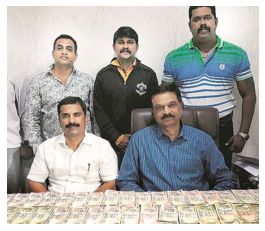

17224
1.0 
 1 11 करोड़ की ब्लैकमनी के साथ बिजनेसमैन अरेस्ट पुराने 1000 500 के नोट बरामद #BlackMoney #Maharashtra


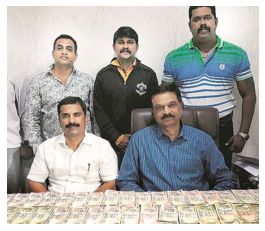

32142
1.0 
 महाराष्ट्र मतगणना से पहले पुणे के एक काउंटिंग सेंटर के बाहर सुरक्षा व्यवस्था ANI #LokSabhaElections2019 #ElectionResults #ResultsWithBhaskar #countingday #Results2019 #Pune #Maharashtra


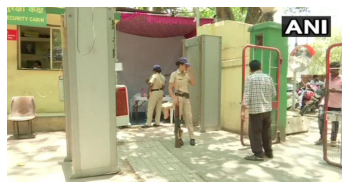

41079
1.0 
 महाराष्ट्र अन्ना का मुख्यमंत्री को पत्र मेरी सुरक्षा हटाई जाए यह बेवजह का खर्च कोई अनहोनी हुई तो मैं खुद जिम्मेदार #annahazare #Maharashtra


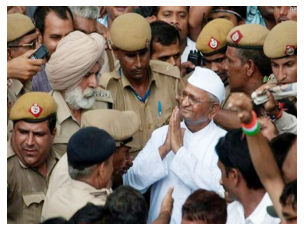

47545
1.0 
 वर्दी का रौब अकोला में लॉकडाउन के नियमों के पालन को लेकर आपस में भिड़े दो पुलिसवाले बीच सड़क पर की मारपीट #Lockdown3 #Maharashtra


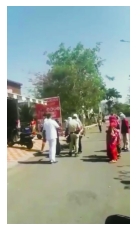

Next set coming




25122
1.0 
 रवि शास्त्री को मिला पसंद का स्टाफ अरुण बॉलिंग श्रीधर फील्डिंग कोच बने #RaviShastri


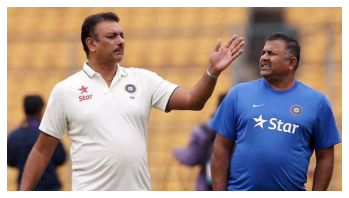

18179
1.0 
 दंगल में नेगेटिव रोल में दिखाने से गीता के असली कोच नाराज कानूनी कार्रवाई की धमकी #Dangal


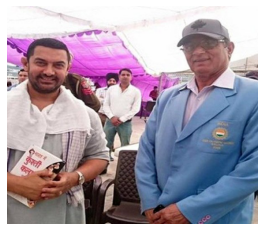

18598
1.0 
 रतन टाटा से लेकर गेट कीपर तक सभी मेरे एड को पसंद करते हैं #BhaskarUtsavRajasthan #PiyushPandey


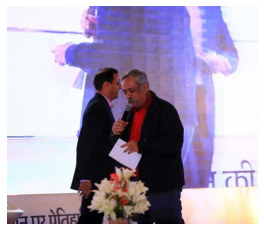

18865
1.0 
 मेट्रो कोच के अंदर लगी आग पूरी ट्रेन में भरा धुआं ब्लू लाइन पर रुकी सर्विस


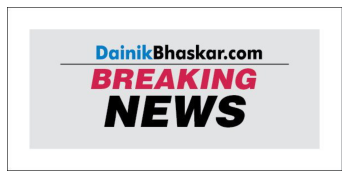

25122
1.0 
 रवि शास्त्री को मिला पसंद का स्टाफ अरुण बॉलिंग श्रीधर फील्डिंग कोच बने #RaviShastri


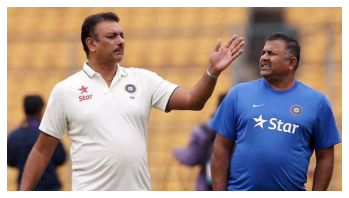

Next set coming






In [ ]:
count = 0
for i in temp:
  if count == 5:
    break
  if len(groups[i]) == 5:
    view_cluster(i)
    count += 1
    print('Next set coming\n\n\n\n')

863
1.0000002 
 सपा सांसद की अफसर को धमकी ट्रैक्‍टर छोड़ो नौकरी करना सिखा देंगे


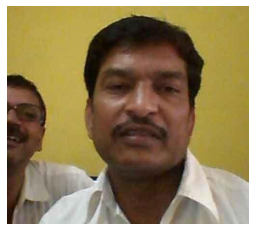

1519
0.029442206 
 क्या जानते हैं आप युवराज सिंह ने यहां लगाया है पैसा #Yuvrajsingh #Money #Invest


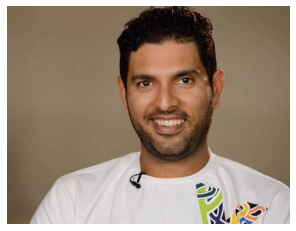

8650
0.028322667 
 सस्पेंशन मामला दानिक्स अधिकारी आज सामुहिक छुट्टी पर


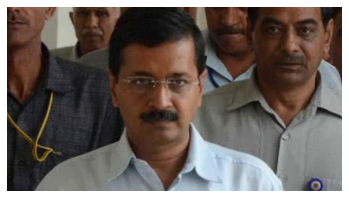

6473
0.02419795 
 #MadhyaPradesh अबु फैजल की सजा से बौखलाया सिमी दीपावली पर कर सकता है हरकत


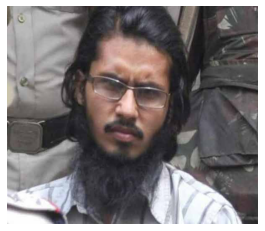

Next set coming




2017
1.0000002 
 बातचीत से पहले #Pakistan ने #Peshawar अटैक के लिए भारत को ठहराया जिम्मेदार


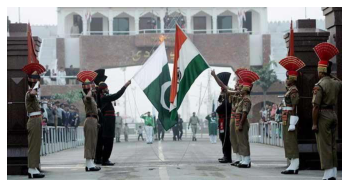

5586
0.023730649 
 चंडीगढ़ में लहराए गए भारत पाक के झंडे सड़क पर उतरे 30 देशों के डेलिगेट्स #Flag #India #Pak


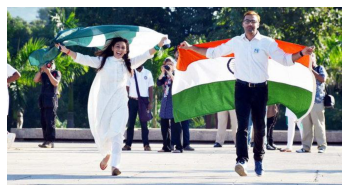

7861
0.022392552 
 भारतीय लड़ाकों को कमजोर मानता है ISIS बिना बताए बना देता है फिदायीन


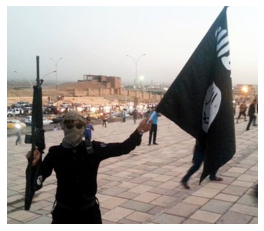

4486
0.02225826 
 15 PHOTOS 15 करोड़ मजदूरों की हड़ताल का कैसा रहा असर #BharatBandh


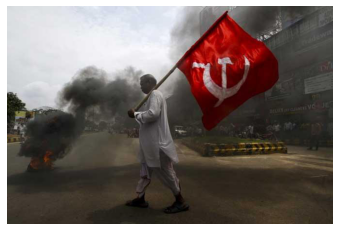

Next set coming




3884
1.0000002 
 भारत में 14 साल में घटे 61000 करोड़पति दूसरे देशों की ली नागरिकता


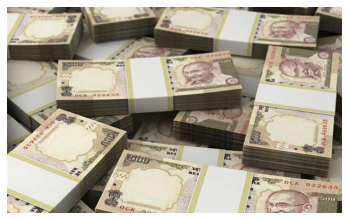

4024
0.025912607 
 7 सिक्युरिटी फीचर्स के साथ आएंगे करंसी नोट नंबर पैटर्न भी होगा अलग


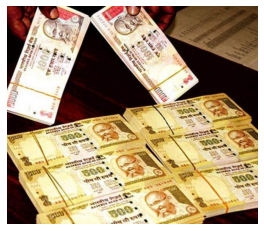

2460
0.022867333 
 ग्रीस बेलआउट पैकेज पर समझौता हुआ यूरोजोन से बाहर निकलने का संकट टला #Greece #Bailout


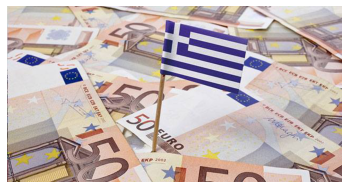

5328
0.022062292 
 गैंगस्टर के घर छापे में मिली डायरी कॉन्स्टेबल से DIG तक को घूस देने का जिक्र


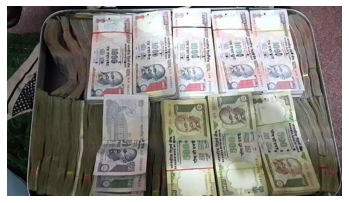

Next set coming




4337
1.0000001 
 ये है #Fashion101 की फेवरेट 5 हॉटेस्ट सेलिब्रिटी मेकप लाइन्स #MakeupLines #CelebrityMakeup


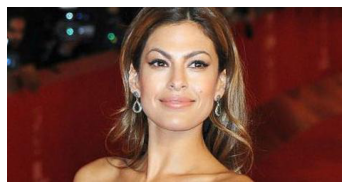

9994
0.026661938 
 इंटरव्यू में सनी से पूछे गए ऐसे सवाल जिसे देख भड़के बॉलीवुड स्टार्स


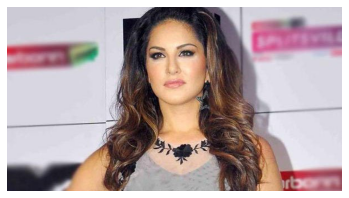

9399
0.02633283 
 कैटरीना कैफ ने तोड़ी चुप्पी बोलीं किसने कहा कि मेरा ब्रेकअप हो गया


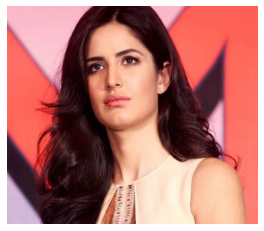

8505
0.023250217 
 Ex ब्वॉयफ्रेंड को आज भी फॉलो करती हैं दीपिका जानें सोशल अकाउंट की बातें


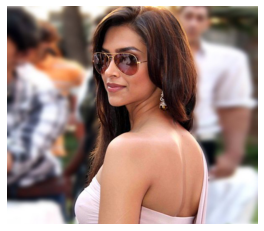

Next set coming




5121
1.0000001 
 #UttarPradesh सोनभद्र में खदान में ब्लास्ट 6 लोगों की मौत की खबर


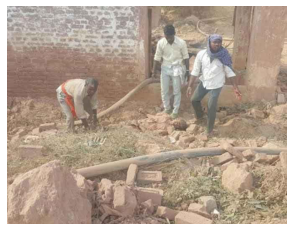

5652
0.3049975 
 #China में दो घंटे के अंदर 13 सीरियल ब्लास्ट 6 लोगों की मौत


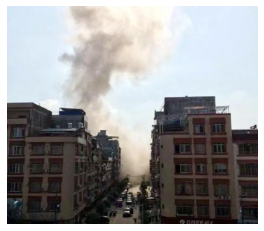

5651
0.24508573 
 चीन के गुआंग्शी में दो घंटे के अंदर पार्सल बम से 15 ब्लास्ट 6 लोगों की मौत


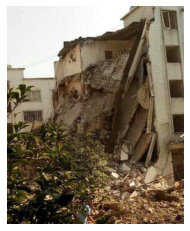

4307
0.021105954 
 पागल आदमी को गांव वालों ने भूत समझकर पेड़ से बांधकर पीटा हालत गंभीर #Ranchi


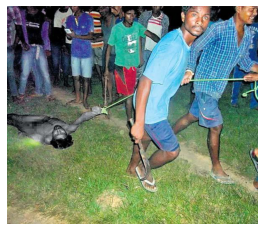

Next set coming






In [ ]:
count = 0
for i in temp:
  if count == 5:
    break
  if len(groups[i]) == 4:
    view_cluster(i)
    count += 1

    print('Next set coming\n\n\n\n')

18780
1.0 
 4th TEST LIVE #INDvEND विराट ने लगाई तीसरी डबल सेन्चुरी भारत 550 रन के पार


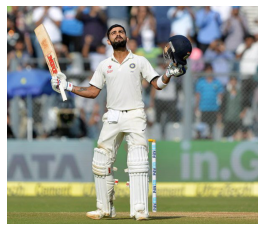

21077
0.167812 
 LIVE #IndvAus पुजारा ने लगाई करियर की तीसरी डबल सेन्चुरी भारत का स्कोर 500 रन के पार #RanchiTest


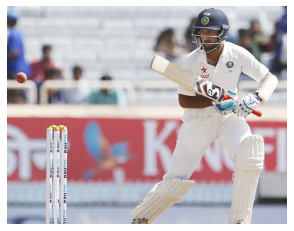

Next set coming




17914
1.0 
 पीटर मुखर्जी को पता था इंद्राणी ने कहां ठिकाने लगाई शीना की बॉडी CBI


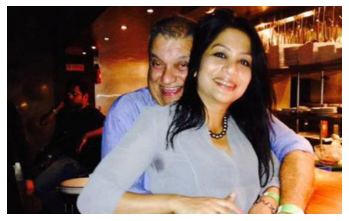

25285
1.0 
 LIVE WC पूनम राउत ने लगाई दूसरी सेन्चुरी 200 रन के करीब भारत #PoonamRaut


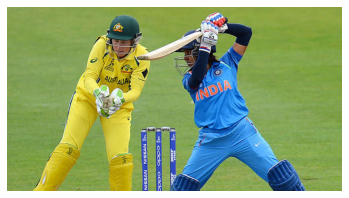

Next set coming




5977
1.0 
 बिना इजाजत एकता यात्रा निकाल रहे हार्दिक पटेल पुलिस हिरासत में #HardikPatel


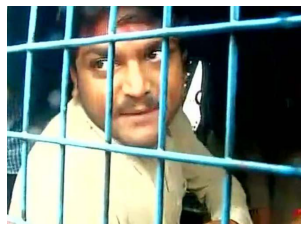

24084
0.3615988 
 MP किसानों के परिवार से मिलने जा रहे हार्दिक पटेल को पुलिस ने हिरासत में लिया #HardikPatel #kisanandolan


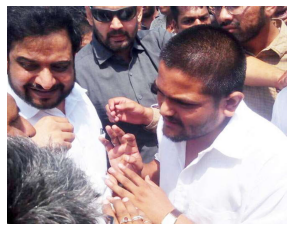

Next set coming




5285
1.0 
 टीम इंडिया को लगा बड़ा झटका हुए वनडे सीरीज से बाहर


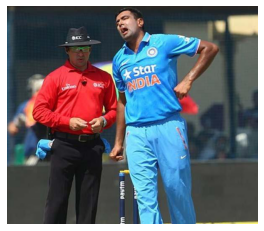

8360
0.28059605 
 टीम इंडिया को लगा झटका चोटिल मोहम्मद शमी ऑस्ट्रेलिया सीरीज से बाहर


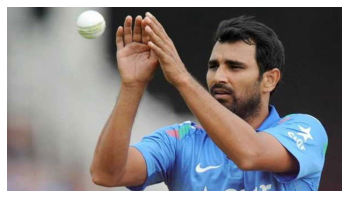

Next set coming




15666
1.0 
 चीन बॉर्डर पर तैनात होंगी ब्रह्मोस आर्मी को मिलेगी 100 सुपरसोनिक क्रूज मिसाइलें #BRAHMOS


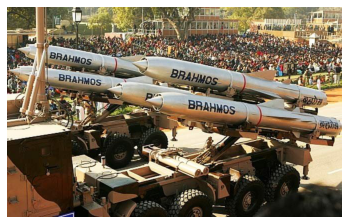

24930
0.18142113 
 बोफोर्स स्कैंडल के 30 साल बाद आर्मी को मिलेंगी नई तोपें चीन बॉर्डर पर तैनात होंगी


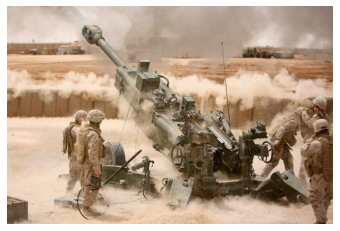

Next set coming






In [ ]:
count = 0
for i in temp:
  if count == 5:
    break
  if len(groups[i]) == 2:
    view_cluster(i)
    count += 1

    print('Next set coming\n\n\n\n')